# **THE IMPACT OF HYPERPARAMETERS TO CONVOLUTIONAL NETWORKS**
## Team members: 

*   Jordi Vaccher
*   Pau Font
*   Esteve Valls
*   Daniel Navarrete






### ***LEARNING RATE (with fixed optimizer SGD) and BATCH SIZE***

This notebook illustrates the use of convolutional networks for a multiclass classificaction over the MNIST dataset and the variation of accuracy while modicating some hyperparameters of the network.

Specifically, in this collab we are actually modificating the **learning rate (with fixed optimizer SGD) and the batch size**.

First of all, we would like to briefly explain the meaning of these two hyperparameters and the utility of them inside the convolutional network:


*   LEARNING RATE: 
  - as we can see by our network, we have used the SGD (Stochastic Gradient Descent) optimization algorithm to train our deep learning neural network. 
  - Learning rate is a hyperparameter that controls the amount of modification impact of the model as a response to the estimated error. This modification is done for each model weight update.
  - Choosing the right "Learning Rate" is challenging as if it is too small the training process could get stuck (and would be so long) whereas if it is too large the learning could be sub-optimal due to too fast weight updating (also arriving to unstable training process).

*   BATCH SIZE: 
  - Defines the number of samples that will be propagated through the network, which is the number of training samples to work through before the model's internal parameters are updated.
  - A training dataset can be divided into one or more batches. Theorically, **SGD** means that Batch Size is equal to 1.
  - It is important to differentiate the Batch Size (number of samples processed before updating the model) and an Eppoch(number of complete passes that the learning algorithm will work though the entire training dataset).
  - The advantage of using a batch size < number of total samples is that requires less memory (as training with fewer samples) and trains faster (as weights are updated after each propagation).
  - One disvantatges is that the smaller the batch the less accurate the estimate of the gradient will be
  - There is a tension between batch size and the speed and stability of the learning process (and, therefore, with Learning Rate).


# **Configure the Learning Rate**
The following formula shows the relationship


```
new_weight = existing_weight — learning_rate * gradient
```

![Gradient descent with small (top) and large (bottom) learning rates. Source: Andrew Ng’s Machine Learning course on Coursera](https://miro.medium.com/max/1000/0*00BrbBeDrFOjocpK.)

Typically learning rates are configured randomly by the user to aproximate value of 0.01. However, it is difficul to choose best learning rate for a neural Network but it is indispensable to do so for great optimitzation.

The below diagram demonstrates different escenarios one can fall into when configuring the learning rate:

![Effect of various learning rates on convergence (Img Credit: cs231n)](https://miro.medium.com/max/574/0*uIa_Dz3czXO5iWyI.)

Remember that LR affects the velocity of convergion to a local minimum in our neural network.


```
Less training time, less money spend on GPU cloud compute
```

In order to successfully estimate a good learning rate it is recommended to start training the model initially with a very low LR and increasing it at each iteration. Consequently, if we plot the LR against loss, we can see (as shown below) that there is a point where the loss gets to its minimum. Experience says that LR should ideally be somewhere to the left of the lowest point of the graph (if it is after, loss starts to increase and model becomes unstable).

![Learning rate (log) against Loss](https://miro.medium.com/max/488/0*Ibt82oiSXBw6YbGm.)







# **Configure the Batch Size**


On the one hand, if we use SGD, we only use a single sample to calculate gradient each time, which may well cause noise due to inefficientcy of the noise of samples. This corresponds to wasting time and resources and maybe even not converging at all.
Problem is that SGD is intractable for large datasets as it computes loss for each training sample:

```
L(θ)=1n∑ni=1ℓ(f(x(i);θ),y(i))
```

Insted, we usually use mini-batch gradient descent where a batch of *m* samples ( where *m << size dataset* ) which fasten the convergence of the model.
```
L(θ)=1m∑mi=1ℓ(f(x(i);θ),y(i))
```


Depending on the model, data and loss function we can choose the size of batches, which is usually set as a potential of 2.


**# Relationship between both Hyperparameters**

According to a paper "Published as a conference paper at ICLR 2018":

```
"We can often achieve the benefits of decaying the learning rate by instead increasing the batch size
during training. Our findings enable the efficient use of
vast batch sizes, significantly reducing the number of parameter updates required to train a model.
This has the potential to dramatically reduce model training times." 

```

 Theory  of * "One weird trick for parallelizing convolutional neural networks "* suggests that:


```
When multiplying the batch size by k, one should multiply the learning rate by sqrt(k) to keep the variance in the gradient expectation constant.
```

Larger minibatch size means more "accurate" gradients (as it is closer to the "true" gradient if taking the whole- batch training). Higher barch size also allows stable training with higher learning rates.

As said in ["Accurate, Large Minibatch SGD"](https://arxiv.org/abs/1706.02677):


```
"The more accurate your gradients, the larger steps you can take without detriment."
```


# **CODE**

Install environemnt:

In [0]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

Import libraries used to create our Convolution Network using pythorch:

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchvision import datasets, transforms

In [0]:
seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

Define our model:

  - in **init** method we create the layers we are going to need and store them as member variables

  - in **forward** method we implement the forward pass computation, making use of the layers we created in the constructor

In [0]:
class Net(nn.Module):
  def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(4*4*50, 500)
      self.fc2 = nn.Linear(500, 10)
  
  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return F.log_softmax(x, dim=1)

Now we proceed to create a function that trains over an epoch. Note that, as we are facing a multiclas classification problem we use NLL (Negative Log LikeliHood as loss function).

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

It is important to evaluate the performance of the model over a validation data set:

In [0]:
 def validate(model, device, loader):
    model.eval()  # let's put the model in evaluation mode
 
    validation_loss = 0
    correct = 0
 
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
    validation_loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),accuracy))
 
    return (validation_loss, accuracy)

Now we proceed to load MNISD, to normalize it and to define the batch_size both for training and for validation.

In [0]:
def load_MNSID(train_batch_size, valid_batch_size):
  #default:
  #   train_batch_size = 128
  #   valid_batch_size = 1000

  mnist_mean = 0.1307
  mnist_stddev = 0.3081
  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('./data',
                    train=True,
                    download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((mnist_mean,), (mnist_stddev,))
                    ])),
      batch_size=train_batch_size,
      shuffle=True)
  
  valid_loader = torch.utils.data.DataLoader(
      datasets.MNIST('./data',
                    train=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((mnist_mean,), (mnist_stddev,))
                    ])),
      batch_size=valid_batch_size,
      shuffle=True)
  return (train_loader, valid_loader)

And finally, we are able to create the network and set the __learning rate__:

In [0]:
def neural_model_lr(learning_rate):
  print("\n\n********** Following results using LEARNING RATE = {} **********".format(str(learning_rate)))
  (train_loader, valid_loader) = load_MNSID(train_batch_size=128, valid_batch_size=1000)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
      train_losses.extend(epoch_losses)
      (valid_loss, accuracy) = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_x.append(len(train_losses) - 1)

  plt.gcf().clear()
  plt.plot(train_losses, 'b-')
  plt.plot(valid_x, valid_losses, 'r-')
  plt.show()
  return (accuracy)

Or also we are able to create the network with an specific learning rate (default is **0.01**)and changing the **batch size**:

In [0]:
def neural_model_batch_size(train_batch_size, valid_batch_size):
  print("\n\n********** Following results using TRAIN BATCH SIZE = {} **********".format(str(train_batch_size)))
  (train_loader, valid_loader) = load_MNSID(train_batch_size, valid_batch_size)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(80, model, device, train_loader, optimizer, epoch)
      train_losses.extend(epoch_losses)
      (valid_loss, accuracy) = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_x.append(len(train_losses) - 1)

  plt.gcf().clear()
  plt.plot(train_losses, 'b-')
  plt.plot(valid_x, valid_losses, 'r-')
  plt.show()
  return (accuracy)

# **PROGRAM TO CHECK DEPENDENCY BETWEEN TIME & ACCURACY AND LEARNING RATE:**
We proceed to create an array of learning rates based from 10 pows:

```
[100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
```
We are also appending all the accuracies getten from each training model to an arrray Accuracy vector which later on will be plot in order to sum up the algorithms made.

Moreover, we are also printing the time consumption for each model and the estimated remaining time





********** Following results using LEARNING RATE = 100.0 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286393
Train Epoch: 1 [10240/60000 (17%)]	Loss: 91.745880
Train Epoch: 1 [20480/60000 (34%)]	Loss: 48.361809
Train Epoch: 1 [30720/60000 (51%)]	Loss: 52.562889
Train Epoch: 1 [40960/60000 (68%)]	Loss: 69.366852
Train Epoch: 1 [51200/60000 (85%)]	Loss: 59.411682

Validation set: Average loss: 52.7115, Accuracy: 1032/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 55.371609
Train Epoch: 2 [10240/60000 (17%)]	Loss: 79.255241
Train Epoch: 2 [20480/60000 (34%)]	Loss: 63.694000
Train Epoch: 2 [30720/60000 (51%)]	Loss: 97.523560
Train Epoch: 2 [40960/60000 (68%)]	Loss: 80.081833
Train Epoch: 2 [51200/60000 (85%)]	Loss: 46.041088

Validation set: Average loss: 84.3299, Accuracy: 1009/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 81.642227
Train Epoch: 3 [10240/60000 (17%)]	Loss: 62.480438
Train Epoch: 3 [20480/60000 (34%)]	Loss: 68.429230
Train Epoch: 3 [30720/60000 (51%)]	Loss: 88.1

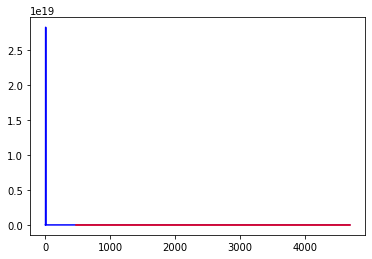

Computed in 110.60384798049927 seconds-


********** Following results using LEARNING RATE = 10.0 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291643
Train Epoch: 1 [10240/60000 (17%)]	Loss: nan
Train Epoch: 1 [20480/60000 (34%)]	Loss: nan
Train Epoch: 1 [30720/60000 (51%)]	Loss: nan
Train Epoch: 1 [40960/60000 (68%)]	Loss: nan
Train Epoch: 1 [51200/60000 (85%)]	Loss: nan

Validation set: Average loss: nan, Accuracy: 980/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: nan
Train Epoch: 2 [10240/60000 (17%)]	Loss: nan
Train Epoch: 2 [20480/60000 (34%)]	Loss: nan
Train Epoch: 2 [30720/60000 (51%)]	Loss: nan
Train Epoch: 2 [40960/60000 (68%)]	Loss: nan
Train Epoch: 2 [51200/60000 (85%)]	Loss: nan

Validation set: Average loss: nan, Accuracy: 980/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: nan
Train Epoch: 3 [10240/60000 (17%)]	Loss: nan
Train Epoch: 3 [20480/60000 (34%)]	Loss: nan
Train Epoch: 3 [30720/60000 (51%)]	Loss: nan
Train Epoch: 3 [40960/60000 (68%)]	Loss: nan
Train Epoc

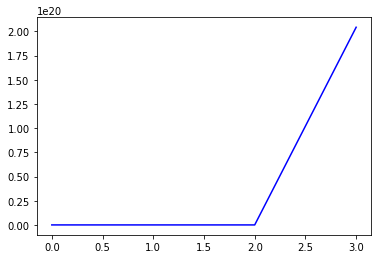

Computed in 108.37023639678955 seconds-


********** Following results using LEARNING RATE = 1.0 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308428
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.298083
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.302615
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.297905
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.307423
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.306436

Validation set: Average loss: 2.3073, Accuracy: 1032/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.321424
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.319781
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.300920
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.302274
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.309940
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.297267

Validation set: Average loss: 2.3062, Accuracy: 1135/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.303391
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.313468
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.309336
Train Epoch: 3 [30720/6

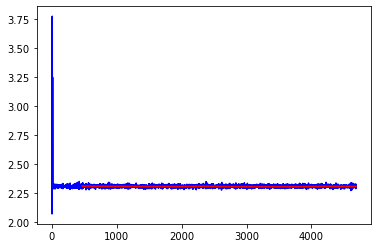

Computed in 108.28178405761719 seconds-


********** Following results using LEARNING RATE = 0.1 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294379
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.246581
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.086868
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.081181
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.019833
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.082687

Validation set: Average loss: 0.0492, Accuracy: 9834/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.041188
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.037789
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.032775
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.048770
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.034636
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.040333

Validation set: Average loss: 0.0346, Accuracy: 9885/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.010937
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.028009
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.021263
Train Epoch: 3 [30720/6

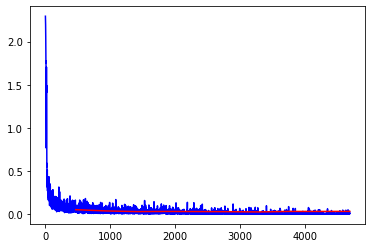

Computed in 107.8093843460083 seconds-


********** Following results using LEARNING RATE = 0.01 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300905
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.624138
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.423759
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.311681
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.276314
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.201586

Validation set: Average loss: 0.1541, Accuracy: 9531/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.178614
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.156410
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.125909
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.077724
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.191687
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.141527

Validation set: Average loss: 0.0928, Accuracy: 9727/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.120389
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.106188
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.071228
Train Epoch: 3 [30720/6

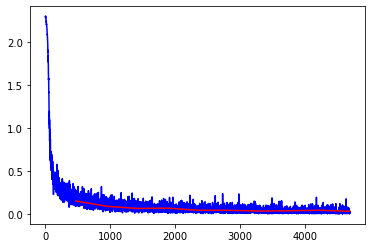

Computed in 108.94056010246277 seconds-


********** Following results using LEARNING RATE = 0.001 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312614
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.249830
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.171362
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.065727
Train Epoch: 1 [40960/60000 (68%)]	Loss: 1.894702
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.625477

Validation set: Average loss: 1.3303, Accuracy: 7965/10000 (80%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.344043
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.993216
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.749480
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.700248
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.586256
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.424573

Validation set: Average loss: 0.4200, Accuracy: 8948/10000 (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.476580
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.352819
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.387324
Train Epoch: 3 [30720

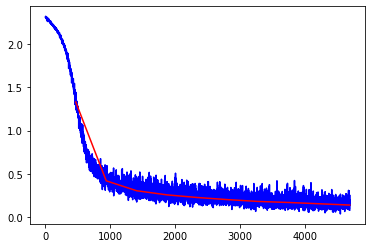

Computed in 110.76058387756348 seconds-


********** Following results using LEARNING RATE = 0.0001 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301996
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.301329
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.298950
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.291331
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.278720
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.267873

Validation set: Average loss: 2.2567, Accuracy: 1543/10000 (15%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.258048
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.248669
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.234884
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.229417
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.227186
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.211102

Validation set: Average loss: 2.2037, Accuracy: 4009/10000 (40%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.210085
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.203508
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.188157
Train Epoch: 3 [3072

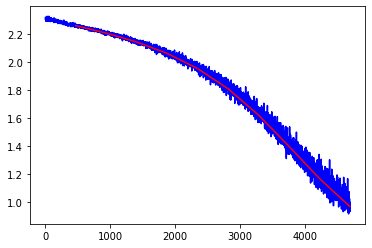

Computed in 109.85655379295349 seconds-


********** Following results using LEARNING RATE = 1e-05 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311091
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.294900
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.298603
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.291401
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.290730
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.301602

Validation set: Average loss: 2.2960, Accuracy: 901/10000 (9%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.301056
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.284082
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.303160
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.305649
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.280362
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.300361

Validation set: Average loss: 2.2922, Accuracy: 1007/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.280731
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.295896
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.287201
Train Epoch: 3 [30720/6

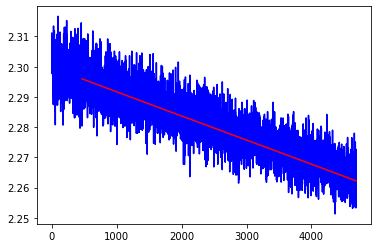

Computed in 109.11023187637329 seconds-


In [0]:
rates = [100/pow(10, i) for i in range(0, 8)]
accuracies_lr = []
times_lr = []

for i, rate in enumerate(rates):
  start_time = time.time()
  accuracies_lr.append(neural_model_lr(rate))
  elapsed_time = time.time()-start_time
  times_lr.append(elapsed_time)
  print("Computed in {} seconds-".format(elapsed_time))

# **PLOTTING ACCURACY vs LEARNING RATE**
We are actually plotting the value of the learning rate vs the accuracy in % get from training the models just before.

We have used logarithmic axis in order to improve the resolution of the plot.

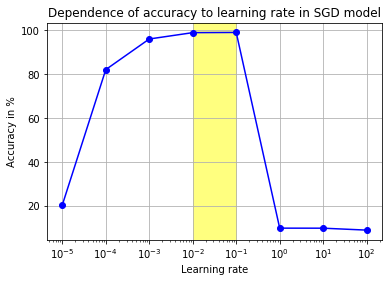

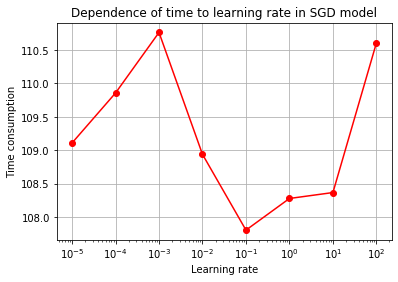

In [0]:
# LEARNING RATE vs ACCURACY
plt.gcf().clear()
plt.xlabel('Learning rate')
plt.ylabel('Accuracy in %')
plt.title('Dependence of accuracy to learning rate in SGD model')
plt.grid(True)
plt.semilogx(rates, accuracies_lr,'bo-')
plt.axvspan(10e-3, 10e-2, color='yellow', alpha=0.5)
plt.show()

# LEARNING RATE vs TIME CONSUMPTION
plt.gcf().clear()
plt.xlabel('Learning rate')
plt.ylabel('Time consumption')
plt.title('Dependence of time to learning rate in SGD model')
plt.grid(True)
plt.semilogx(rates, times_lr,'ro-')
plt.show()

# **PROGRAM TO CHECK DEPENDENCY BETWEEN TIME & ACCURACY AND BATCH SIZE:**
We proceed to create an array of BATCH SIZE  based from a pow of 2.


```
[8, 16, 32, 64, 128, 256, 512]
```

We are also appending all the accuracies getten from each training model to an arrray Accuracy vector which later on will be plot in order to sum up the algorithms made.

Moreover, we are also printing the time consumption for each model and the estimated remaining time



********** Following results using TRAIN BATCH SIZE = 8 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.335552
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.750719
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.715610
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.760824
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.059582
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.052923
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.300795
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.007873
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.096590
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.369991
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.022417
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.657543
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.015407
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.350240
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.179088
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.073963
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.303921
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.007295
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.329628
Train Epoc

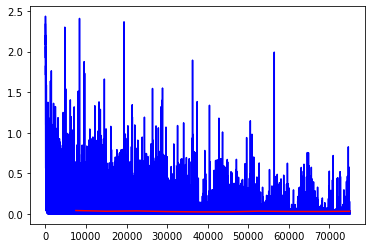

Computed in 251.6958839893341 seconds-


********** Following results using TRAIN BATCH SIZE = 16 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282450
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.939711
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.499660
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.384792
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.057752
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.244038
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.308146
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.339575
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.156492
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.073235
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.152480
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.185371
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.018132
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.081301
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.413276
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.028947
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.015236
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.104822
Train E

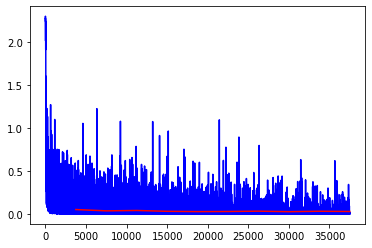

Computed in 187.04314708709717 seconds-


********** Following results using TRAIN BATCH SIZE = 32 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.338239
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.682114
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.245553
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.157114
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.353537
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.116243
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.237571
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.094773
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.055036
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.126942
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.074753
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.285198
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.031488
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.058976
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.198561
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.015613
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.018328
Train Epoch: 1 [43520/60000 (73%)]	Loss: 0.103882


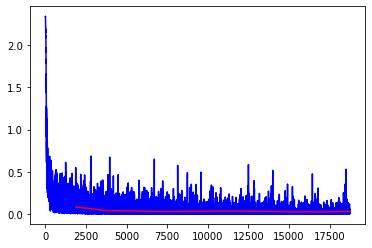

Computed in 143.57890033721924 seconds-


********** Following results using TRAIN BATCH SIZE = 64 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304982
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.912582
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.249431
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.308425
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.103550
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.270949
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.232366
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.154703
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.072270
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.053156
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.065827
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.217868

Validation set: Average loss: 0.1032, Accuracy: 9682/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.069724
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.163855
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.052331
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.344811
Train Epoch: 2 [20480/60000 (34%)]	Lo

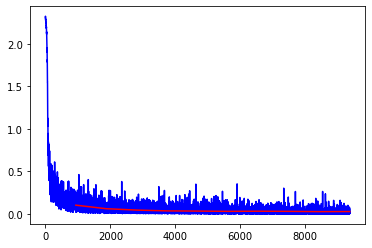

Computed in 121.16383218765259 seconds-


********** Following results using TRAIN BATCH SIZE = 128 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320456
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.468066
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.312854
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.262389
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.202941
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.157895

Validation set: Average loss: 0.1690, Accuracy: 9486/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.133809
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.166403
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.092545
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.127227
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.179814
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.149086

Validation set: Average loss: 0.0920, Accuracy: 9732/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.047357
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.116508
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.079978
Train Epoch: 3 [3072

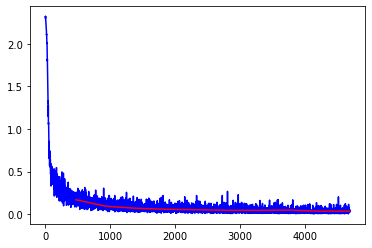

Computed in 111.3502459526062 seconds-


********** Following results using TRAIN BATCH SIZE = 256 **********
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317504
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.617268
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.364055

Validation set: Average loss: 0.2719, Accuracy: 9210/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.251431
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.263566
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.188528

Validation set: Average loss: 0.1528, Accuracy: 9551/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.141875
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.119908
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.122158

Validation set: Average loss: 0.1113, Accuracy: 9678/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.143304
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.183897
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.126582

Validation set: Average loss: 0.0920, Accuracy: 9726/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.1224

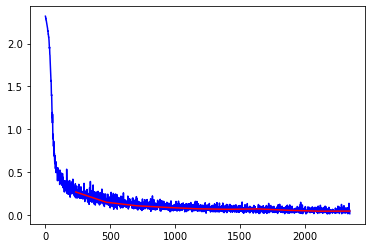

Computed in 107.14014101028442 seconds-


In [0]:
batch_sizes = [pow(2, i) for i in range(3, 9)]
accuracies_batch_size = []
times_batch_size = []

for i, batch_size in enumerate(batch_sizes):
  start_time = time.time()
  accuracies_batch_size.append(neural_model_batch_size(batch_size, 1000))
  elapsed_time = time.time()-start_time
  times_batch_size.append(elapsed_time)
  print("Computed in {} seconds-".format(elapsed_time))

# **PLOTTING ACCURACY vs BATCH SIZE**
We are actually plotting the value of the batch size vs the accuracy in % get from training the models just before.

We have used logarithmic axis in order to improve the resolution of the plot.

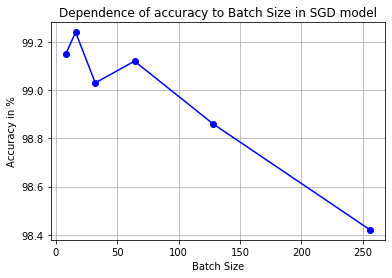

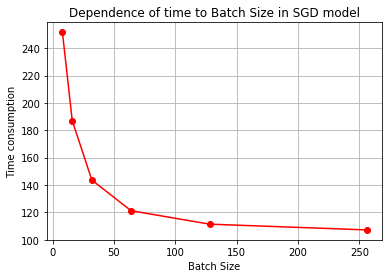

In [0]:
# BATCH SIZE vs ACCURACY
plt.gcf().clear()
plt.xlabel('Batch Size')
plt.ylabel('Accuracy in %')
plt.title('Dependence of accuracy to Batch Size in SGD model')
plt.grid(True)
plt.plot(batch_sizes, accuracies_batch_size,'bo-')
plt.show()

# BATCH SIZE vs TIME CONSUMPTION
plt.gcf().clear()
plt.xlabel('Batch Size')
plt.ylabel('Time consumption')
plt.title('Dependence of time to Batch Size in SGD model')
plt.grid(True)
plt.plot(batch_sizes, times_batch_size,'ro-')
plt.show()

# **CONCLUSION**

### **LEARNING RATE**
We have learned, therefore:
  - Using a low learning rate takes lots of epochs to converge, which requires too much computational requirements. Therefore, using the limited number of epochs set (as 10 in our case), we do not achieve full convergence which provokes suffering siginifcant loss. Tiny learning rates result in a failure to train while large rates in unstable training.

  -  By using a higher learning rate, neural network convergence is not achieved due to exceeding speed.

  - We have seen by experiment that optimal Learning rates are aroung 0.001-0.01; where the accuracy is stable around an accuracy of 99%.

  - The difference in time consumption is almost none. We can see that there is not much change in time consumption so we decide that the best learning rate is around 0.01 (as accuracy is 99% and time consumption is stable).
### **BATCH SIZE**

After the study of the **batch size** hyperparameter we have reached some conclusions:

  - We can see that there is a almost no variation of the accuracy on changing the batch size. However, we can see that time consumption does change even reducing by half that time. Therefore, we can conclude that the best batch size is taking into account the time consumption as accuracy nearly is mantained.
  
  - In our case, we have found that a batch size of 64 is optimal for a set learning rate of 0.01 (default set for the batch size variation experiment).
